# Import các module

In [ ]:
import tensorflow as tf
import pandas as pd
import os

In [4]:
import torch
# Kiểm tra xem có GPU hay không
if torch.cuda.is_available():    
    device = torch.device("cuda")

    print('Chúng ta sẽ sử dụng:', torch.cuda.get_device_name(0))
else:
    print('Không có GPU khả thi nên sử dụng CPU')
    device = torch.device("cpu")

Không có GPU khả thi nên sử dụng CPU


# Load data

In [ ]:
train_path = 'train.csv'
# tổng có 33759 dòng trong file
df = pd.read_csv(train_path, index_col=0).sample(frac=1)[:10000]
df

,label,text
18805,Suc khoe,huyện chim sệ cánh tại gia_đình anh uông văn t...
17087,Suc khoe,sự hiểu_biết về mối nguy_hại của thuốc_lá còn ...
19218,Suc khoe,pata đề_nghị châu á mạnh_tay với cúm_gà hiệp_h...
15815,Phap luat,cơ_quan cảnh_sát điều_tra công_an tỉnh bà rịa ...
31113,Van hoa,nhạc_sĩ dương thụ ' hãy để sự say_mê cuốn đi '...
...,...,...
2220,Chinh tri Xa hoi,chương_trình hợp_tác giữa princeton academy th...
11678,Kinh doanh,fedex đưa thêm máy_bay vào khai_thác tại vn cô...
19223,Suc khoe,cai_nghiện ' tại_ngoại ' viện sức_khỏe tâm_thầ...
2741,Chinh tri Xa hoi,chợ hoa bên sông tiền cứ vào_khoảng từ rằm thá...


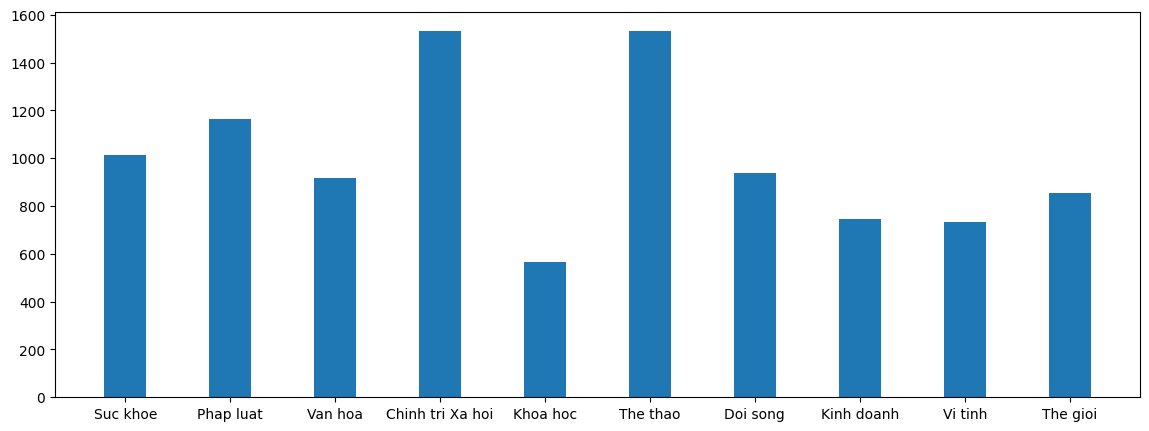

In [ ]:
# Thống kê các lớp
from collections import Counter
import matplotlib.pyplot as plt

labels = df['label'].values
texts = df['text'].values

x = dict(Counter(labels)).keys()
height = dict(Counter(labels)).values()
plt.figure(figsize=(14,5))
plt.bar(x=x, height=height, width=0.4)
plt.show()

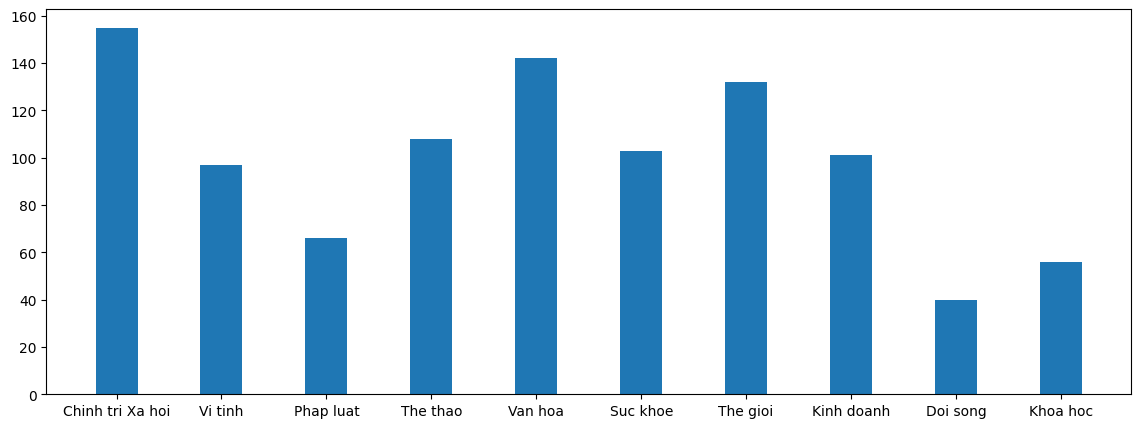

In [ ]:
# load data test
test_path = 'test.csv'
df_test = pd.read_csv(test_path, index_col=0).sample(frac=1)[:1000]

labels_test = df_test['label'].values
texts_test = df_test['text'].values

x = dict(Counter(labels_test)).keys()
height = dict(Counter(labels_test)).values()
plt.figure(figsize=(14,5))
plt.bar(x=x, height=height, width=0.4)
plt.show()

# Chuẩn hóa dữ liệu từ văn bản thành số

### Chuẩn hóa labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(labels)
y = le.transform(labels)

y_test = le.transform(labels_test)

### Chuẩn hóa văn bản

In [ ]:
from transformers import AutoTokenizer
# Tokenizer để encode đầu vào văn bản
model_pretrain = 'vinai/phobert-base'
tokenizer = AutoTokenizer.from_pretrained(model_pretrain)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Chúng ta sẽ chọn maxlen là 512
avg = 0
maximum = 0
for sent in texts:
    length = len(sent.split())
    avg += length
    maximum = max(length, maximum)
print(maximum)
print(avg/len(texts))

9054
386.1466


In [ ]:
MAX_LEN = 256 # dùng 256 từ để phân loại văn bản

In [ ]:
X = tokenizer(list(texts), max_length=MAX_LEN, padding='max_length', truncation=True) # truncation là để cắt bỏ bớt phần dài hơn max_length
X_test = tokenizer(list(texts_test), max_length=MAX_LEN, padding='max_length', truncation=True)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_inputs = torch.tensor(X.input_ids)
train_masks = torch.tensor(X.attention_mask)
train_labels = torch.from_numpy(y)

# Tạo Dataloader cho train set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data) # dùng để tạo ra các bath với dữ liệu ngẫu nhiên
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size) 

test_inputs = torch.tensor(X_test.input_ids)
test_masks = torch.tensor(X_test.attention_mask)
test_labels = torch.from_numpy(y_test)

# Tạo Dataloader cho test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Load model

In [ ]:
from transformers import  RobertaForSequenceClassification
# Mô hình ngôn ngữ Phobert của vinai sử dụng pre-train của RoBERTa, đây là các model sử dụng có hiệu suất cao trong tiếng Việt
model =  RobertaForSequenceClassification.from_pretrained(model_pretrain, 
                                                          num_labels = 10,
                                                          output_hidden_states=False,
                                                          output_attentions = False)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('Model BERT có {:} Tham số khác nhau.\n'.format(len(params)))

print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')
for p in params[5:-4]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

Model BERT có 201 Tham số khác nhau.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (64001, 768)
roberta.embeddings.position_embeddings.weight             (258, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias           (768,)
roberta.

In [ ]:
from transformers import AdamW, BertConfig

In [ ]:
# Thuật toán tối ưu
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - mặc định 5e-5
                  eps = 1e-8 # args.adam_epsilon  - mặc định is 1e-8.
                )

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Số lần backward
epochs = 4

# Tổng số bước training
total_steps = len(train_dataloader) * epochs

# Tạo learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# hàm tính độ chính xác của nhãn dự đoán và nhãn thực tế (ta sẽ chọn vị trí có giá trị cao nhất có khả năng là nhãn đúng trong preds)
# pred = [[0,1,2,1.5], [5,6,4,3]] -> argmax -> [[2], [6]] -> flatten -> [2,6]
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

# Nhận đầu vào là giây, đầu ra là chuỗi hàng hh:mm:ss
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

# Training code dựa trên `run_glue.py`, script ở đây:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# đặt giá trị seed để khi dùng random nó có thể cho ra kết quả giống nhau
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Lưu lại giá trị lỗi để kiểm tra
loss_values = []

model.to(device)
# Bắt đầu train
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Kiểm tra thời gian train
    t0 = time.time()

    total_loss = 0

    # Đưa model vào training mode
    # train chỉ là thay đổi chế độ, nó không thực hiện training gì cả
    # dropout và`batchnorm layers sẽ có hành vi khác nhau trong quá trình training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # Mỗi batch trong data
    for step, batch in enumerate(train_dataloader):

        # kiểm tra thời gian train 40 bath là bao lâu
        if step % 80 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # lấy dữ liệu từ dataloader
        # Khi lấy dữ liệu ta cần phải sử dụng phương thức 'to' để đưa về kiểu thiết bị mình muốn sử dụng (ví dụ như GPU hoặc CPU) 
        # mỗi batch bao gồm 3 pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Luôn luôn clear gradients đã được tính toán từ lần trước trước khi backward, 
        # PyTorch không tự làm việc này tự động, vì tích lũy gradients là "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Thực hiện forward model (lan truyền tiến), nó sẽ trả về loss (thay vì output) vì chúng ta có truyền vào label
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
   
        # outputs sẽ là một tuple và chúng ta cần lấy loss từ tuple đó
        loss = outputs[0]

        # Chúng ta sẽ tính lỗi trên từng batch rồi tính trung bình lỗi khi kết thúc
        # loss là một Tensor bao gồm một giá trị, hàm .item() sẽ trả về giá trị đó
        total_loss += loss.item()

        # Thực hiện backward để tính gradients (lan truyền ngược)
        loss.backward()

        # Cắt định mức của gradients thành 1.0, nó sẽ giúp ngăn chặn vấn đề "exploding gradients"
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Cập nhật các tham số sử dụng gradients
        # opimizer đưa ra các "update rule" là các tham số sẽ được sửa đổi dựa trên gradients, learning rate,...
        optimizer.step()

        # Cập nhật learning rate
        scheduler.step()

    # Tính toán trung bình lỗi khi train
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # lưu lại các giá trị lỗi vào mảng 
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # Sau khi train, chúng ta sẽ kiểm tra lại độ hiệu quả của model trên tập validate

    print("")
    print("Running Validation...")

    t0 = time.time()

    # đặt model vào trạng thái evaluation
    # dropout và`batchnorm layers sẽ có hành vi khác nhau trong quá trình evaluation
    model.eval()

    # Theo dõi các biến thông số
    test_loss, test_accuracy = 0, 0
    nb_test_steps, nb_test_examples = 0, 0

    # Đánh giá cho mỗi epochs
    for batch in test_dataloader:
        
        # Đưa batch thành GPU mode
        batch = tuple(t.to(device) for t in batch)
        
        # Lấy dữ liệu từ dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Cho model biết rằng là sẽ không tính toán và lưu gradients, để tiết kiệm bộ nhớ và tăng tốc độ xá thực
        with torch.no_grad():        
            # forward để tính toán logit predictions
            # Nó sẽ trả về logits thay vì loss vì chúng ta không truyền vào labels
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        # Lấy giá trị logits từ model, các giá trị đầu ra trước khi áp dụng hàm kích hoạt như softmax
        logits = outputs[0]

        # Chuyển logits và labels thành CPU mode
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # TÍnh toán độ chính xác cho batch này
        tmp_test_accuracy = flat_accuracy(logits, label_ids)
        
        # Tích lũy tổng độ chính xác
        test_accuracy += tmp_test_accuracy

        # Lưu lại số lượng các batch
        nb_test_steps += 1

    # In ra độ chính xác và thời gian validate
    print("  Accuracy: {0:.2f}".format(test_accuracy/nb_test_steps))
    print("  Test took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    80  of    313.    Elapsed: 0:01:46.
  Batch   160  of    313.    Elapsed: 0:03:36.
  Batch   240  of    313.    Elapsed: 0:05:25.

  Average training loss: 0.61
  Training epcoh took: 0:07:05

Running Validation...
  Accuracy: 0.88
  Test took: 0:00:15

======== Epoch 2 / 4 ========
Training...
  Batch    80  of    313.    Elapsed: 0:01:50.
  Batch   160  of    313.    Elapsed: 0:03:40.
  Batch   240  of    313.    Elapsed: 0:05:29.

  Average training loss: 0.22
  Training epcoh took: 0:07:08

Running Validation...
  Accuracy: 0.91
  Test took: 0:00:15

======== Epoch 3 / 4 ========
Training...
  Batch    80  of    313.    Elapsed: 0:01:50.
  Batch   160  of    313.    Elapsed: 0:03:39.
  Batch   240  of    313.    Elapsed: 0:05:29.

  Average training loss: 0.12
  Training epcoh took: 0:07:08

Running Validation...
  Accuracy: 0.91
  Test took: 0:00:15

======== Epoch 4 / 4 ========
Training...
  Batch    80  of    313.    Elapsed

In [ ]:
# sử dụng report classification để đánh giá model
# giống với validate trong quá trình train
model.eval()
  
predictions , true_labels = np.array([]), np.array([])

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  pred_flat = np.argmax(logits, axis=1).flatten()
  
  predictions = np.concatenate([predictions, pred_flat])
  true_labels = np.concatenate([true_labels, label_ids])

predictions = predictions.astype(np.int32)
true_labels = true_labels.astype(np.int32)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       155
           1       0.68      0.42      0.52        40
           2       0.92      0.80      0.86        56
           3       0.94      0.89      0.91       101
           4       0.85      0.95      0.90        66
           5       0.92      0.96      0.94       103
           6       0.95      0.94      0.95       132
           7       0.98      0.98      0.98       108
           8       0.91      0.96      0.93       142
           9       0.93      0.98      0.95        97

    accuracy                           0.91      1000
   macro avg       0.89      0.88      0.88      1000
weighted avg       0.91      0.91      0.91      1000



# Implement

In [ ]:
data = pd.read_csv(test_path, index_col=0).sample(frac=1)[:5]
data

,label,text
24053,Suc khoe,đi chân_đất dễ bị mụn cóc ở bàn_chân khi còn b...
22351,Suc khoe,gặp nguy vì móng tay giả các móng tay giả từng...
28143,The gioi,toà_án ukraina xét đơn kiện của yanukovic hôm_...
2868,Chinh tri Xa hoi,nhà tự cháy bùng_phát ở tây ninh nhiều căn nhà...
19489,Phap luat,chủ đầu_tư dự_án khu đô_thị mới cái rồng lừa 2...


In [ ]:
actual_label = data['label'].values
texts_pred = data['text'].values

X_pred = tokenizer(list(texts_pred), max_length=MAX_LEN, padding='max_length', truncation=True)

input_ids = torch.tensor(X_pred.input_ids).to(device)
input_mask = torch.tensor(X_pred.attention_mask).to(device)

outputs = model(input_ids, 
                token_type_ids=None, 
                attention_mask=input_mask)

logits = outputs[0]
logits = logits.detach().cpu().numpy()
logits_flat = np.argmax(logits, axis=1).flatten()

pred_label = le.inverse_transform(logits_flat)
print('Nhãn dự đoán:', pred_label)
print('Nhãn thực tế: ',actual_label)

Nhãn dự đoán: ['Suc khoe' 'Suc khoe' 'The gioi' 'Chinh tri Xa hoi' 'Phap luat']
Nhãn thực tế:  ['Suc khoe' 'Suc khoe' 'The gioi' 'Chinh tri Xa hoi' 'Phap luat']


In [ ]:
def pred_label_texts(text):
  # cho vào 1 đoạn văn (nên có hàm xử lý làm sạch text)
  # cho ra label
  X_pred = tokenizer([text], max_length=MAX_LEN, padding='max_length', truncation=True)

  input_ids = torch.tensor(X_pred.input_ids).to(device)
  input_mask = torch.tensor(X_pred.attention_mask).to(device)

  outputs = model(input_ids, 
                  token_type_ids=None, 
                  attention_mask=input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  logits_flat = np.argmax(logits, axis=1).flatten()

  pred_label = le.inverse_transform(logits_flat)
  return pred_label[0]

In [ ]:
index = 0
l = actual_label[index]
p = list(texts_pred)[index]
p

'đi chân_đất dễ bị mụn cóc ở bàn_chân khi còn bé chắc bạn từng nghe nói nếu sờ hay đụng phải da_cóc thì sẽ bị mụn cóc thật_ra bệnh do một loại virus gây ra việc đi chân_không ở những nơi ẩm_ướt như phòng tắm công_cộng phòng xông_hơi hồ bơi sẽ làm tăng nguy_cơ mọc mụn cóc ở bàn_chân mụn cóc là những u nhỏ ở ngoài da bề_mặt thường sần_sùi gây ra bởi virus hpv human papilloma virus hpv xâm_nhập vào da qua những vết trầy_xước bên ngoài mụn cóc có_thể phát_triển trong nhiều tháng mới nhìn thấy được bệnh có_thể gặp ở mọi lứa tuổi nhưng tỷ_lệ mắc phải ở trẻ_em cao hơn vì chúng hiếu_động và thường_xuyên làm trầy_xước chân tay hay đi chân_không cắn móng tay nghịch đất_cát lê_la dưới đất hpv thường sống ở những nơi ấm ẩm nên việc đi chân_đất ở những nơi này sẽ dễ bị mụn cóc bàn_chân hơn làm móng cắt khoé móng chân tay cũng là nguyên_nhân thường gây mụn cóc ở người_lớn nhất là phụ_nữ mụn cóc có_thể lây_lan qua 2 cách tiếp_xúc trực_tiếp với mụn cóc của người_bệnh như sờ cọ sát cầm nắm ngoài_ra bện

In [ ]:
pred_label_texts(p)

'Suc khoe'

In [ ]:
l

'Suc khoe'